In [ ]:
# Authenticate and initialize Earth Engine
import ee
ee.Authenticate()
ee.Initialize(project="intense-terra-417213")

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from osgeo import gdal


In [ ]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Verify the Paths
!ls "/content/drive/My Drive/GEE_Exports/PREDICT"


LST_CanTho_1.tif  LST_CanTho_2.tif  LST_CanTho_3.tif  output


In [ ]:
#  install rasterio using pip
!pip install rasterio


!conda install -c conda-forge rasterio --yes
import rasterio
print(rasterio.__version__)


/bin/bash: line 1: conda: command not found
1.3.10


**Data Exploration**





In [ ]:
import rasterio
import numpy as np

# Paths to TIFF files
tiff_files = [
    "/content/drive/My Drive/GEE_Exports/PREDICT/LST_CanTho_1.tif",
    "/content/drive/My Drive/GEE_Exports/PREDICT/LST_CanTho_2.tif",
    "/content/drive/My Drive/GEE_Exports/PREDICT/LST_CanTho_3.tif"
]

# Function to calculate mean, max, min ignoring NaN values
def analyze_tiff(path):
    with rasterio.open(path) as src:
        data = src.read(1)  # Read the first band
        data = np.ma.masked_invalid(data)  # Mask NaN values

        if np.ma.count(data) > 0:  # Check if there are any non-NaN values
            mean_val = np.mean(data)
            max_val = np.max(data)
            min_val = np.min(data)
        else:
            mean_val = max_val = min_val = np.nan  # Return NaN if all values are NaN

        return mean_val, max_val, min_val

# Apply the function to each TIFF file and print the results
for file in tiff_files:
    mean, max_val, min_val = analyze_tiff(file)
    print(f"File: {file}")
    print(f"Mean: {mean}, Max: {max_val}, Min: {min_val}\n")


File: /content/drive/My Drive/GEE_Exports/PREDICT/LST_CanTho_1.tif
Mean: 30.988855572789696, Max: 51.44086745481218, Min: -1.361232084249366

File: /content/drive/My Drive/GEE_Exports/PREDICT/LST_CanTho_2.tif
Mean: 34.156445371001475, Max: 55.96833286712223, Min: 21.41761406072743

File: /content/drive/My Drive/GEE_Exports/PREDICT/LST_CanTho_3.tif
Mean: 33.73579765059439, Max: 55.99921993552152, Min: 18.206526279608568



In [ ]:
# Configuration: Define paths and directories
output_directory = '/content/drive/My Drive/GEE_Exports/PREDICT'

**Processing GeoTIFF files, handling geospatial data and applying machine learning (Random Forest model)**

In [ ]:
import os
import rasterio
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
# Function to read data to a GeoTIFF file
def read_geotiff(file_path):
    """Read a GeoTIFF file and return the data as a numpy array."""
    with rasterio.open(file_path) as src:
        data = src.read(1)
        print("Loaded data shape:", data.shape, "Expected to flatten to size:", data.size)
        return data, src.transform, src.crs
# Function to write data to a GeoTIFF file
def write_geotiff(data, transform, crs, file_path, shape):
    """Write a numpy array as a GeoTIFF file."""
    try:
        # Check if data size matches the expected product of shape dimensions
        expected_size = shape[0] * shape[1]
        if data.size != expected_size:
            raise ValueError(f"Data size ({data.size}) does not match expected shape ({shape[0]}x{shape[1]}={expected_size})")
        data = data.reshape(shape)
        with rasterio.open(
            file_path, 'w', driver='GTiff',
            height=shape[0], width=shape[1],
            count=1, dtype=str(data.dtype),
            crs=crs, transform=transform
        ) as dst:
            dst.write(data, 1)
    except Exception as e:
        print(f"Error reshaping or writing: {e}")

        print(f"Data shape attempted: {data.shape}, Target shape: {shape}")
# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)

# Load and prepare data
X, y, transforms, crses, shapes = [], [], [], [], []
for year in range(1, 3):
    data, transform, crs = read_geotiff(f'/content/drive/My Drive/GEE_Exports/PREDICT/LST_CanTho_{year}.tif')
    X.append(data.flatten())  # Flatten for model input
    y.append(data.flatten())  # Flatten targets as well
    transforms.append(transform)
    crses.append(crs)
    shapes.append(data.shape)

X = np.array(X)
y = np.array(y)

# Handling NaN values for both features and labels
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)
y = imputer.transform(y)

# Split data into training and testing
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(train_X, train_y)

# Predict future temperature map
predicted = model.predict(test_X)

# Check predicted size and original shapes
print(f"Predicted array size: {predicted.size}")
for shape in shapes:
    print(f"Original shape: {shape}")

# Save the predicted maps as GeoTIFF
for idx, pred in enumerate(predicted):
    write_geotiff(pred, transforms[idx + len(train_X)], crses[idx + len(train_X)], f'predicted_{1 + len(train_X) + idx}.tif', shapes[idx + len(train_X)])


Loaded data shape: (1514, 2310) Expected to flatten to size: 3497340
Loaded data shape: (1514, 2310) Expected to flatten to size: 3497340
Predicted array size: 1657310
Original shape: (1514, 2310)
Original shape: (1514, 2310)
Error reshaping or writing: Data size (1657310) does not match expected shape (1514x2310=3497340)
Data shape attempted: (1657310,), Target shape: (1514, 2310)


In [ ]:
#import os
#import rasterio
#import numpy as np
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import train_test_split
#from sklearn.impute import SimpleImputer

def read_geotiff(file_path):
    """Read a GeoTIFF file and return the data as a numpy array."""
    with rasterio.open(file_path) as src:
        data = src.read(1)
        return data, src.transform, src.crs

def write_geotiff(data, transform, crs, file_path, shape):
    """Write a numpy array as a GeoTIFF file."""
    with rasterio.open(
        file_path, 'w', driver='GTiff',
        height=shape[0], width=shape[1],
        count=1, dtype=str(data.dtype),
        crs=crs, transform=transform
    ) as dst:
        dst.write(data, 1)

# the output directory
output_directory = '/content/drive/My Drive/GEE_Exports/PREDICT/output'
os.makedirs(output_directory, exist_ok=True)

# Load and prepare data
data_years = {}
transform_crs = {}
for year in range(1, 3):
    data, transform, crs = read_geotiff(f'/content/drive/My Drive/GEE_Exports/PREDICT/LST_CanTho_{year}.tif')
    data_years[year] = data.flatten()  # Store flattened data
    transform_crs[year] = (transform, crs)

# Prepare data arrays
X = np.array([data_years[1]])  # Features from 2013
y = np.array([data_years[2]])  # Labels from 2023

# Flatten X and y for model compatibility
X = X.reshape(-1, 1)  #  X is two-dimensional
y = y.ravel()  #  y is one-dimensional

# Handling NaN values
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)
y = imputer.transform(y.reshape(-1, 1)).ravel()




In [ ]:
def read_geotiff(file_path):
    """Read a GeoTIFF file and return the data as a numpy array along with its original shape."""
    with rasterio.open(file_path) as src:
        data = src.read(1)
        return data, src.transform, src.crs, data.shape
data_years = {}
transform_crs = {}
original_shapes = {}

for year in range(1, 3):
    data, transform, crs, shape = read_geotiff(f'/content/drive/My Drive/GEE_Exports/PREDICT/LST_CanTho_{year}.tif')
    data_years[year] = data.flatten()  # Store flattened data
    transform_crs[year] = (transform, crs)
    original_shapes[year] = shape  # Store the original shape
# Reshape predictions to the original image dimensions using 2023 data metadata
predictions_shape = original_shapes[2]  # Use the stored original shape
predictions_transform, predictions_crs = transform_crs[2]


**Training and Prediction**

In [ ]:
# Split data into training and testing
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(train_X, train_y)

# Predict for the entire dataset
full_predictions = model.predict(X)

# Reshape predictions to the original image dimensions using 2023 data metadata
predictions_shape = data_years[2].shape
predictions_transform, predictions_crs = transform_crs[2]



In [ ]:
# Dimensions of a numpy array containing model predictions
print("Predictions shape:", predictions_shape)


Predictions shape: (3497340,)


In [ ]:
# Print the shape to debug
print("Original shape of 2023 data:", original_shapes[2])




Original shape of 2023 data: (1514, 2310)


In [ ]:
# Assuming full_predictions is already generated and needs reshaping
predictions_shape = original_shapes[2]  # Correctly reference the original shape

# Check before reshaping
if full_predictions.size != np.prod(predictions_shape):
    print("Error: Mismatch in prediction size and original data shape")
else:
    reshaped_predictions = full_predictions.reshape(predictions_shape)
    predicted_file_path = os.path.join(output_directory, 'predicted_LST.tif')
    try:
        write_geotiff(reshaped_predictions, predictions_transform, predictions_crs, predicted_file_path, predictions_shape)
        print("Predictions successfully saved as GeoTIFF.")
    except Exception as e:
        print(f"Failed to write GeoTIFF: {str(e)}")


Predictions successfully saved as GeoTIFF.


In [ ]:
# Predict for the entire dataset
#full_predictions = model.predict(X).reshape(data_years[2].shape)
# Save the predicted map as GeoTIFF
#write_geotiff(full_predictions, data_years[2][1], data_years[2][2], os.path.join(output_directory, 'predicted_full.tif'), data_years[2][3])

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Assuming test_y and test_X are already defined
test_predictions = model.predict(test_X)

# Calculate MSE
mse = mean_squared_error(test_y, test_predictions)
print(f"Mean Squared Error (MSE): {mse:.2f}")

# Calculate RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Mean Squared Error (MSE): 2.77
Root Mean Squared Error (RMSE): 1.66


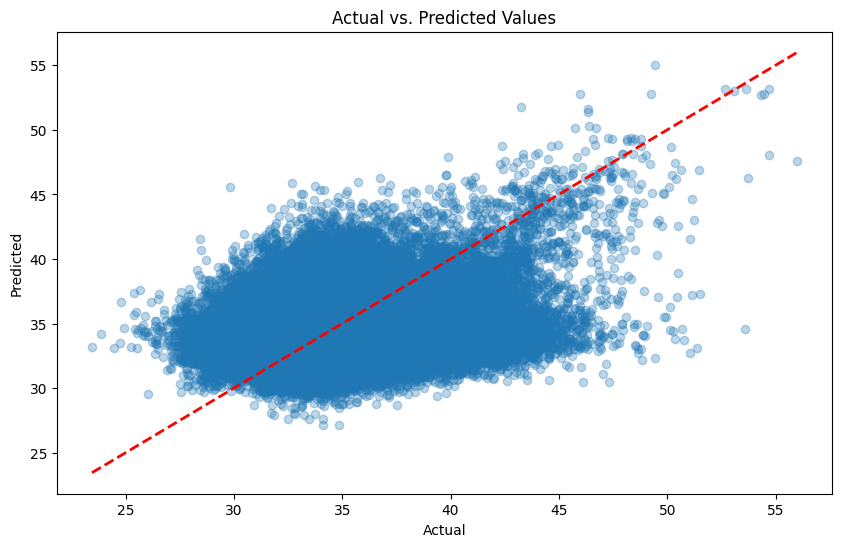

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot for actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(test_y, test_predictions, alpha=0.3)
plt.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'r--', lw=2)  # A red line representing the perfect predictions
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()


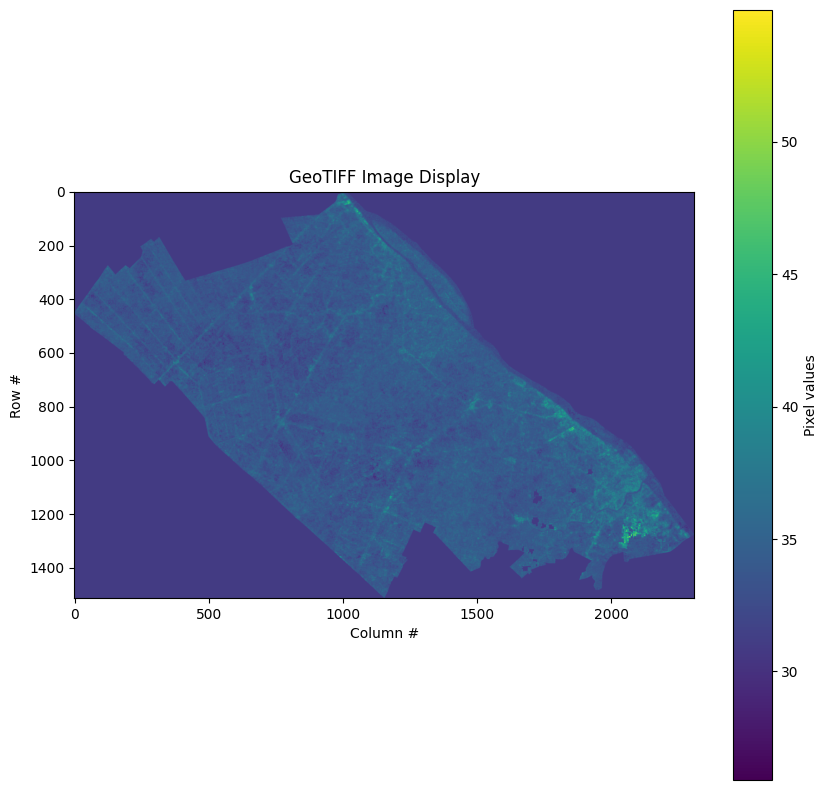

In [ ]:

def show_geotiff(file_path):
    """Read and display a GeoTIFF file."""
    with rasterio.open(file_path) as src:
        data = src.read(1)
        plt.figure(figsize=(10, 10))

        # Display the image
        plt.imshow(data, cmap='viridis')
        plt.colorbar(label='Pixel values')
        plt.title('GeoTIFF Image Display')
        plt.xlabel('Column #')
        plt.ylabel('Row #')
        plt.show()

# the output GeoTIFF file
file_path = '/content/drive/My Drive/GEE_Exports/PREDICT/output/predicted_LST.tif'

# Display the image
show_geotiff(file_path)


In [ ]:
# Paths to TIFF files
tiff_files = [
    "/content/drive/My Drive/GEE_Exports/PREDICT/output/predicted_LST.tif",
]

# Function to calculate mean, max, min ignoring NaN values
def analyze_tiff(path):
    with rasterio.open(path) as src:
        data = src.read(1)  # Read the first band
        data = np.ma.masked_invalid(data)  # Mask NaN values

        if np.ma.count(data) > 0:  # Check if there are any non-NaN values
            mean_val = np.mean(data)
            max_val = np.max(data)
            min_val = np.min(data)
        else:
            mean_val = max_val = min_val = np.nan  # Return NaN if all values are NaN

        return mean_val, max_val, min_val

# Apply the function to each TIFF file and print the results
for file in tiff_files:
    mean, max_val, min_val = analyze_tiff(file)
    print(f"File: {file}")
    print(f"Mean: {mean}, Max: {max_val}, Min: {min_val}\n")

File: /content/drive/My Drive/GEE_Exports/PREDICT/output/predicted_LST.tif
Mean: 32.48956338227335, Max: 54.981293080835364, Min: 25.897274932928102

